# Import

In [1]:
import numpy as np
import pandas as pd
import timm
import random
import os
from PIL import Image
import torch

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import tqdm
from torch import nn
from torch import optim

import json
import time

# Set seed (Reproduce result)

In [2]:
SEED = 123456789

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Split data

In [3]:
data = pd.read_csv('cassava-leaf-disease-classification/train.csv')
choosen_prob = np.random.rand(len(data))
train_df = data[choosen_prob >= 0.9]
val_df = data[choosen_prob < 0.1]

In [4]:
data.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

<AxesSubplot:>

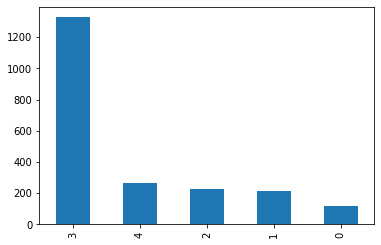

In [5]:
val_df.label.value_counts().plot(kind="bar")

<AxesSubplot:>

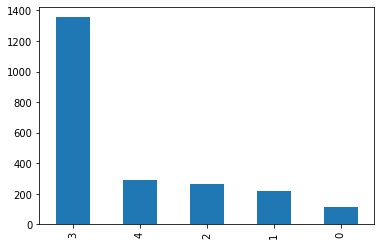

In [6]:
train_df.label.value_counts().plot(kind="bar")

# Hyper params

In [7]:
EXP_NAME = 'exp_06'

###########################################
MODEL_NAME = 'tf_efficientnet_b3_ns'
IM_SIZE = 300
###########################################
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
LR_STEP = 10
EPOCH = 50
WARMUP_EPOCH = 50
WEIGHT_DECAY = 1e-4
GRADIENT_COEFF = 2
WEIGHTS = None
##########################################
CLASS_NUM = [1087, 2189, 2386, 13158, 2577]
WEIGHTS = [1 / weight for weight in CLASS_NUM]
NORM_WEIGHTS = [weight / sum(WEIGHTS) for weight in WEIGHTS]
# NORM_WEIGHTS = None
print(NORM_WEIGHTS)
##########################################
VAL_BATCH_SIZE = BATCH_SIZE
############################################
NUM_WORKER = 16

[0.4070720457073391, 0.20214130364727165, 0.18545151453641143, 0.03362876680984022, 0.1717063692991376]


In [8]:
HYPER_PARAMS = {
    'EXP_NAME': EXP_NAME,

    'MODEL_NAME': MODEL_NAME,
    'IM_SIZE': IM_SIZE,

    'BATCH_SIZE': BATCH_SIZE,
    'LEARNING_RATE': LEARNING_RATE,
    'LR_STEP': LR_STEP,
    'EPOCH': EPOCH,
    'WARMUP_EPOCH': WARMUP_EPOCH,
    'WEIGHT_DECAY': WEIGHT_DECAY,
    'NORM_WEIGHTS': NORM_WEIGHTS,

    'VAL_BATCH_SIZE': VAL_BATCH_SIZE,

    'NUM_WORKER': NUM_WORKER,
}

# Data augmentation

In [9]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
COLOR_JILTER = (0, 0.3)

train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((IM_SIZE, IM_SIZE), interpolation=Image.BICUBIC),
     transforms.ColorJitter(brightness=COLOR_JILTER, contrast=COLOR_JILTER, saturation=COLOR_JILTER, hue=COLOR_JILTER),
     transforms.RandomResizedCrop((IM_SIZE, IM_SIZE)),
     transforms.RandomRotation(45),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.Normalize(mean, std)])

val_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((IM_SIZE, IM_SIZE), interpolation=Image.BICUBIC),
     transforms.Normalize(mean, std)])

# Dataset

In [10]:
class CassavaDataset(Dataset):
    def __init__(self, image_dir, df, transform=None):
        self.image_dir = image_dir
        self.df = df.reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.loc[index]
        label = row.label
        image_name = row.image_id
        
        image = Image.open(os.path.join(self.image_dir, image_name))
        image = np.array(image)
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

In [11]:
train_image_dir = 'cassava-leaf-disease-classification/train_images'
train_dataset = CassavaDataset(train_image_dir, train_df, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True, 
                                           num_workers=NUM_WORKER)

val_image_dir = 'cassava-leaf-disease-classification/train_images'
val_dataset = CassavaDataset(val_image_dir, val_df, transform=val_transform)
val_loader = torch.utils.data.DataLoader(val_dataset, 
                                           batch_size=VAL_BATCH_SIZE, 
                                           shuffle=False, 
                                           num_workers=NUM_WORKER)

# Model

In [12]:
device = torch.device("cuda")
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=5)

In [13]:
class_weights = None
if NORM_WEIGHTS != None:
    class_weights = torch.FloatTensor(NORM_WEIGHTS).cuda()
    
criterion = nn.CrossEntropyLoss(weight=class_weights)
linear_scaled_lr = 8.0 * LEARNING_RATE * GRADIENT_COEFF * BATCH_SIZE / 512.0
# optimizer = optim.SGD(model.parameters(), lr=linear_scaled_lr, momentum=0.9, weight_decay=WEIGHT_DECAY)
optimizer = optim.Adam(model.parameters(), lr=linear_scaled_lr, weight_decay=WEIGHT_DECAY)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP)
model.cuda()
print('Convert model to CUDA')

Convert model to CUDA


# Train and Val

In [14]:
def freeze_bn(model):
    model.eval()
    model.classifier.train()
    model.conv_head.train()
    model.bn2.train()

In [15]:
def train_one_epoch(epoch, model, train_loader, criterion, optimizer, finetune_on_bn=True, logs_file=None):
    if finetune_on_bn == False:
        freeze_bn(model)
    else:
        model.train()
        
    running_loss = 0.0
    scaler = torch.cuda.amp.GradScaler()
    for i, data in enumerate(tqdm.tqdm(train_loader), 0):
        inputs, labels = data
        with torch.cuda.amp.autocast():
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = model(inputs)
            assert outputs.dtype is torch.float16
            loss = criterion(outputs, labels)
            loss = loss / GRADIENT_COEFF
            assert loss.dtype is torch.float32
        
        scaler.scale(loss).backward()
#         scaler.unscale_(optimizer)
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        
        if (i + 1) % GRADIENT_COEFF == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            running_loss += loss.item()
            
            if logs_file != None:
                logs_file.write('Training loss at epoch {}, iteration {}: {}\n'.format(epoch, i, running_loss / i * GRADIENT_COEFF))
    if logs_file != None:
        logs_file.write('------------------------------------------------\n')
           
    return running_loss / len(train_loader)

In [16]:
def validate(epoch, model, val_loader, logs_file=None):
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for data in tqdm.tqdm(val_loader):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
        
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            running_loss += loss.item()
    
    if logs_file != None:
        logs_file.write('Validating loss at epoch {}: {}\n'.format(epoch, running_loss / len(val_loader)))
        logs_file.write('Validating accuracy at epoch {}: {}\n'.format(epoch, correct / total))
        logs_file.write('**************************************************\n')
        
    torch.save(model.state_dict(), 'models/exp_{}_time_{}_epoch_{}_acc_{}.pth'.format(EXP_NAME, int(time.time()), epoch, correct / total))
    return running_loss / len(val_loader), correct / total

# def frezze_top(Model):
#     pass

In [ ]:
import time

train_loss_list = []
val_acc_list = []
val_loss_list = []
with open('logs/logs_{}_{}.txt'.format(EXP_NAME, int(time.time())), 'w') as logs_file:
    logs_file.write(json.dumps(HYPER_PARAMS))
    logs_file.write('\n')
    logs_file.write('**************************************************\n')
    
    for epoch in range(EPOCH):
        train_loss = 0.0
        if epoch < WARMUP_EPOCH:
            train_loss = train_one_epoch(epoch, 
                                         model, 
                                         train_loader, 
                                         criterion, 
                                         optimizer, 
                                         finetune_on_bn=False, 
                                         logs_file=logs_file)
        else:
            train_loss = train_one_epoch(epoch, 
                                         model, 
                                         train_loader, 
                                         criterion, 
                                         optimizer, 
                                         logs_file=logs_file)
        val_loss, val_acc = validate(epoch, 
                                     model, 
                                     val_loader, 
                                  
                                     logs_file=logs_file)

        print('Train loss: {}'.format(train_loss))
        print('Val loss: {}'.format(val_loss))
        print('Val acc: {}'.format(val_acc))
        
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

 47%|████▋     | 33/70 [00:38<00:31,  1.17it/s]

# Visualize train loss and val loss

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

print(train_loss_list)
print(val_acc_list)
print(val_loss_list)

plt.plot(train_loss_list)
plt.plot(val_acc_list)
plt.plot(val_loss_list)

plt.show()